# Введение

**Просмотр фильмов на оригинальном языке - это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, таким образом чтобы студент понимал 50 - 70% диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню сложности он соответствует. Однако это требует больших временных затрат, что наша задача исправить!**

**Цель проекта:** Разработать ML решение для автоматического определения уровня сложности англоязычных фильмов. 

**P.S.: Хочу обратить внимание Проверяющего на следующее. =)**

Изначально была идея разработать проект и просто выложить его на GitHub. Однако, в ходе разработки было выяснено, что код проекта будет выполнятся очень долго, это стало понятно уже на этапе формирования токенов слов из исходных субтитров. Для упрощения работы и быстроты исследования, а также тренировки ведения журнала разработки через Git. Принял решение, что полученные после вычислений фреймы с частотами слов, а также модель сохранять в отдельные файлы. Все важные этапы разработки проекта присутствуют ничего не удалено, оставлены результаты работы кода. Убраны только лишние ячейки с пробными версиями функций, а также различные варианты тестирования локальных методов. При желании или необходимости пересобрать проект или получить новые фреймы с данными, всегда можно изменить тип ячеек из неисполняемых в режим кода и всё запустить заново.

P.P.S.: Понимаю, что в реальном проекте имеет смысл создавать отдельный файл под библиотеку функций, можно добавить другой, в котором будет обработка исходных файлов с субтитрами, затем еще один для новых субтитров, разработку модели свести в четвёртый, а также добавить, какой-нибудь `Main`, в котором все будет объединятся в одно целое. Но такой подход я пока не изучал и не пробовал, пока в нём не уверен и времени на изучение нет совсем. Потому код оставил все одном и убрал в неисполняемый тип ячеек, то что не надо использовать в данный момент. 

# Подготовка библиотек, функций и констант

## Загрузка библиотек

In [1]:
# Загрузка основных библиотек
import pandas as pd
import numpy as np

# Подгружаем библеотеку для чтения субтитров
import pysrt
# Подгружаем библеотеку для получения списка специальных символов
import string
# Подгружаем библеотеки для выделения слов из текста
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Подгружаем библиотеку для преобразования слов в их исходное значение (к корню)
from nltk.stem import WordNetLemmatizer
# Подгружаем библиотеку для разделения выборки на обучающую и тестовую
from sklearn.model_selection import train_test_split

# Подгрузим модель CatBoost для разнообразия
from catboost import CatBoostClassifier
from catboost import cv, Pool

# Метрики для оценки качества модели
from sklearn.metrics import f1_score, accuracy_score, silhouette_score

# Для расчета меры близости между текстами добавим метрики расстояний
from scipy.spatial.distance import cityblock, euclidean, cosine

# Для расчета меры близости между текстами добавим корреляционные метрики похожести строк
from scipy.stats import pearsonr, spearmanr, kendalltau

# Для построения диаграмм подгрузим данную библиетеку
from matplotlib import pyplot as plt

# Добавим библиотеку для итераций по словарям
import operator

# Добавим библиотеку случаностей
import random

# Добавим библиотеку для подсчета количества вхождений элемента в список
from collections import Counter

# Подгружаем библиотеки для получения списка файлов из папки
from os import listdir
from os.path import isfile, join

## Функции используемые в проекте

### Свод базовых функций

In [2]:
# 1
# Функция для загрузки данных, хранящих информацию об уровнях английского
def func_load(file):
    
    # загрузим данные
    try:
        data_levels = pd.read_excel(file)
        
    except:
        print('Проблема с данными, попробуйте снова.')
    
    return data_levels

# 2
# Функция для формирования общего массива слов из фремов с уровнями английского
def united_words(*args):
    
    united = []
    
    # запустим обработку фреймов с учетом, того что их может быть много
    for arg in args:        
        for column in arg.columns:
            # пройдемся циклом по всем элементам из столбцов до появления пропусков
            for word in (np.array(arg[arg[column].isna() == False][column])):
                united.append(word.strip())

    return united

# 3
# Функция аналогичная вышестоящей, однако здесь мы объдиним фреймы в один, сохранив разделение по классам.
def class_united(*frames):
    
    # объявим конечный фрейм
    result_frame = pd.DataFrame()
    
    # распакуем фремы
    arr_frames = []
    
    for frame in frames:
        arr_frames.append(frame)
        
    # объединим в один фрейм
    result_frame = pd.concat(arr_frames)
    
    # обновим индексацию
    result_frame = result_frame.reset_index(drop=True)
    
    return result_frame
    
    
# 4
# Функция для удаления лишних символов
def remove_symbol(text, symbols_to_delete):
    for symbol in symbols_to_delete:
        text = text.replace(str(symbol), '')
    return text

# 5
# Функция для разделения текста по словам с удалением стоп-слов
def transform_text(text):
    
    # разделяем текст по словам (токенам)
    word_tokens = word_tokenize(text)
    # убираем стоп слова из текста
    word_tokens = [word for word in word_tokens if word not in STOP_WORDS]
    # приводим слова к изначальной форме
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    
    return lemmas

# 6
# Функция для чтения субтитров и преобразования их в удобный для обработки вид
def subs_transform(file):
    
    # чтение субтитров из файла
    subs = pysrt.open(file, encoding='iso-8859-1')

    # объединим субтитры в один единый текст
    subs_union = "".join([str(sub) for sub in subs])

    # уберём все лишние символы, такие как цифры и специальные символы вместе со знаком перевода строки
    subs_union = remove_symbol(subs_union, DIGITS + PUNCTUATIONS)

    # переведём всё в нижний регистр
    subs_union = subs_union.lower()
    
    # преобразуем текст субтитров в список слов
    subs_union = transform_text(subs_union)
    
    return subs_union

# 7
# Функция для масштабирования частоты появления слов
def freq_word_scal(subs, freq_word_subs):
        '''
        Данная функция необходима, для того избавится от проблемы больших и маленьких текстов.
        Имеется ввиду следующее, если фильм длинной около 3 часов, то количество слов в субтитрах 
        будет существенно больше чем в фильме длинной час. Для этого, будем находить долю частоты
        появления конкретного слова от общего числа слов в тексте. 
        '''
        # найдём общее количество слов в субтитрах
        count_words = len(subs)
        
        # запустим цикл по словарю частот слов, получая доли от общего числа слов в субтитрах
        for key in freq_word_subs.keys():
            try:
                freq_word_subs[key] = np.longdouble(freq_word_subs[key] / count_words)
            except:
                freq_word_subs[key] = 0
            
        return freq_word_subs
    
# 8
# Функция для подсчета частоты повторения слов
def frequency_word(list_word_from_text, list_word_by_levels):
    
    # объявим словарь, который будет собирать частоты появления слов
    freq_words = {}
    
    # запускаем цикл по словам из списка уникальных значений, на основе которых, 
    # выстраиваются уровни владения языком (уровневый список)
    for level_word in list_word_by_levels:
        # для удобства, вначале будем присваивать ноль для базового значения частот слов
        freq_words[level_word] = 0
        # запускаем цикл по словам из списка текста
        for text_word in list_word_from_text:
            # подсчёт частот производится на основе равенства слов из уровнего списка со словами из текста
            if(level_word == text_word):
                freq_words[level_word] += 1
                
    # произведём масштабирование частот слов
    freq_words = freq_word_scal(list_word_from_text, freq_words)
                
    return freq_words

# 9
# Функция для получения списка файлов в заданной папке
def func_list_files(folder_path):
    
    # получим список файлов
    list_files = [folder_path + f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    
    return list_files

# 10
# Функция, осуществляющая разметку текстов из заданной папки, c получением общего фрейма данных
def text_markup(folder_path, combined_unique_words):
    
    # получим список файлов для разметки
    list_files = func_list_files(folder_path)
    
    # объявим матрицу частот слов, переменную для хранения субтитров,
    # массив, содержащий текущий набор частот слов и результирующий фрейм данных
    matrix_values = [] 
    subs = ''
    freq_words = []
    result = pd.DataFrame()
    
    # запустим обработку всех текстовых файлов в заданном каталоге
    for file in list_files:
        
        # обработка текущего файла субтитров
        subs = subs_transform(file)
        # получим массив значений частот слов
        freq_words = [val for val in frequency_word(subs, combined_unique_words).values()]
        
        # добавим получившуюся вектор-строку в матрицу значений
        matrix_values.append(freq_words)
        
    # сформируем обобщённый фрейм данных, который будет содержать частоты слов для каждого фильма 
    result = pd.DataFrame(data=matrix_values, columns=combined_unique_words)
    
    return result

# 11
# Расчёт меры близости строк
def strings_dist(row, *args):
    # объявим массив, который будет содержать аргументы функции
    args_values = []
    for arg in args:
        args_values.append(arg)
        
    # зададим словарь функций
    func_dict = {
        'cityblock': cityblock(row, args_values[0]),
        'euclidean': euclidean(row, args_values[0]),
        'cosine': cosine(row, args_values[0])    
    }
    
    # вычислим близость строк
    for key in func_dict.keys():
        if(key == args_values[1]):
            return func_dict[key]

### Функции для разметки новых данных

In [3]:
# 1
# Функция для расчёта расстояний между строками, а также их похожести
def str_distance(vector1=None, vector2=None, method=None):
    
    # зададим словарь функций
    func_dict = {
        'cityblock': cityblock(vector1, vector2),
        'euclidean': euclidean(vector1, vector2),
        'cosine': cosine(vector1, vector2),
        'pearsonr': pearsonr(vector1, vector2),
        'spearmanr': spearmanr(vector1, vector2),
        'kendalltau': kendalltau(vector1, vector2)
    }
    
    # вычислим близость строк
    try:
        for key in func_dict.keys():
            if(key == method):
                return func_dict[key]
    except:
        print("Пожалуйста задайте все необходимые параметры для вычислений.")
        
# 2
# Функция для определения сложности текста на основе принадлежности топ слов к тому или иному уровню сложности
def level_top_words(vector, levels, top=np.nan):
    """
    Суть данной функции в том, что мы берём топ N слов из текста (определяем при запуске функции) 
    и сверяем со словами, которые есть в уровнях языка.
    В каком уровне получилось больше вхождений слов из текста, значит тот уровень и выбираем.
    """
    
    # зададим переменную для хранения получившегося уровня сложности
    result_lvl = None
    
    # избавимся от слов, которых в тексте не было
    zero = pd.Series([0])
    vector = vector[~np.isin(vector, zero)]
    
    # выделяем заданный топ слов
    if(top < len(vector)):
        top_words = vector.sort_values(ascending=False).head(top)
    else:
        top_words = vector.sort_values(ascending=False)
    
    # объявим словарь, в который будем помещать подсчитанное количество слов
    levels_counts = {}
    
    # запускаем цикл по уровням сложности
    for lvl in levels.columns:
        count = 0
        for word in top_words.index:
            if (word in levels[lvl].values):
                count += 1
                
        # передаём значения в словарь
        if(lvl == 'A1'):
            levels_counts[lvl] = count / 3
        else:
            levels_counts[lvl] = count
    
    # определим уровень с самым высоким числом вхождения слов
    result_lvl = max(levels_counts.items(), key=operator.itemgetter(1))[0]
    
    return result_lvl

# 3
# Функция для определения сложности текста на основе расчета расстояний близости строк
def func_proximity_lines(vector, mean_in_class):
    
    # объявим словарь для хранения результатов
    level_dict = {}
    
    # объявим массивы для хранения результатов расчетов близостей
    result = []
       
    # запускаем цикл по методам расчета близости строк
    for method in ['cityblock', 'euclidean', 'cosine', 'pearsonr', 'spearmanr', 'kendalltau']:
        
        # объявляем массив для хранения расстоний
        arr_dist = []
        
        # запускаем цикл для расчета близости по массиву, содержащему усреднённые значения для каждой категории
        classes = mean_in_class.columns
        for clas in classes:
            arr_dist.append(str_distance(vector, mean_in_class[clas], method))
            
        # определим что в данный момент вычисляем, расстояние или похожесть
        if(method in ['cityblock', 'euclidean', 'cosine']):        
            # определим минимальное значение расстояния
            value = min(arr_dist)
        else:
            # определяем максимальное значение похожести
            value = max(arr_dist)
            
        # проверим нет ли одинаковых значений 
        indices = [index for index, val in enumerate(arr_dist) if val == value]
        # проверка на количество похожих значений
        if(len(indices) == 1):
            result.append(classes[indices][0])
        else:
            # так как одинаковые значения редкое событие, но обратотать его надо,
            # то обработаем его хотябы случайным выбором.
            result.append(classes[random.choice(indices)][0])
            
    return result

# 4
# Функция для расчета принадлежности к классу на основе предсказаний модели обученной на исходных данных
def class_on_model(vector, model):
    
    return model.predict(vector)[0]

# 5
# Решающая функция для определения принадлежности текста к уровню сложности языка
def solve_lvl_lang(vector, frames_united_lvl):
    """
    Данная функция будет определящей в том случае если, "ансамбль из слабых классификаторов" не сможет самостоятельно 
    определить принадлежность текста к тому или иному уровню сложности.
    В данной функции будем определять принадлежность текста к уровню сложности на основе всех встречаемых слов в тексте.
    Сравнивать будем с фреймом данных, в котором хранятся все возможные слова из британского и американского фремов.
    """
    level_lang = level_top_words(vector, frames_united_lvl, top=len(vector))
    
    return level_lang

# 6
# Функция для определения конечной сложности текста
def ensemble_classifiers(vector, british, americ, mean_in_class, model):
    """
    Данная функция представляет собой ансамбль из слабых классификаторов.
    Исходя из того, что у нас нет возможности произвести "грамотную" разметку данных,
    то делать ее будет исходя из работы нескольких классификаторов, где "голосованием"
    будем определять, к какому уровню сложности стоит отнести тот или иной текст.
    """
    
    # зададим массив, который будет содержать результаты работы разных классификаторов
    result_class = []
    
    # уберём лишнее поле с названием
    vector = pd.Series(vector.drop('Movie'))
    
    # найдём общий фрейм по уровням языка
    frames_united_lvl = class_united(british, americ)
    
    ## Не получилось правильно реализовать данную функцию. Она постоянно показывает категорию А2, что не верно.
    
    # получим уровни сложности относительно разновидностей языка (британский и американский)
    # из-за наличия множества слов на уровнях A будем брать, только топ 20 самых встречаемых слов в тексте
    #result_class.append(level_top_words(vector, british, top=100))
    #result_class.append(level_top_words(vector, americ, top=100))    
    #result_class.append(level_top_words(vector, frames_united_lvl))
    
    # получим уровни сложности на основе близостей текста к усреднённым значениям по каждому классу
    result_class.extend(func_proximity_lines(vector, mean_in_class))
    
    # получим уровень сложности на основе предсказаний модели обученной на исходных данных
    result_class.append(class_on_model(vector, model))
    
    # вычислим сколько было вхождений полученных классов в массиве
    result = max(Counter(result_class).items(), key=operator.itemgetter(1))[0]
    
    return result

## Класс "предсказание для новых файлов"

In [ ]:
# Создадим класс, который будет получать на вход путь к файлу
# и говорить к какому уровню сложности относятся данные субтитры
class predict_lvl:
    """
    Идея добавить данный класс появилась только по завершению проекта, потому его не использовал.
    В целом само существование класса не обязательно, однако работа выполненная с данным классом выглядит более лаконично.
    В конечном итоге данный класс лучше использовать для получения предсказаний для новых субтитров, 
    а также если разворачивать программу ввиде бота на сайте или в телеграмме, как раз класс будет более интересным
    решением.
    """    
    
    # метод для инициализации файлов
    def __init__(self, path_file):        
        self.subs = text_markup(path_file)
    
    # метод для расчёта предсказаний
    def predict(self, british_lvls, americ_lvls, mean_in_class_vals, model):        
        new_subs_lvl = []        
        for ind in self.subs.index:
            new_subs_lvl.append((ensemble_classifiers(self.subs.loc[ind], 
                                                      british_lvls, americ_lvls, mean_in_class_vals, model)))
        return new_subs_lvl

## Перечень используемых в проекте констант

In [4]:
# Цифры
DIGITS = ''.join([str(digit) for digit in range(10)])

# Знаки препинания и символ перевода строки
PUNCTUATIONS = string.punctuation + '\n'

# Выделяем список стоп-слов
STOP_WORDS = set(stopwords.words('english'))

# Загрузка данных

In [5]:
# Из-за того, что начальный уровень А1 по содержит большую часть слов, то использовать классификатор принадлежности
# на основе уровней сложности по сути становится невозможно. Из-за этого уберём данный класс из выборки

# загрузим данные по уровням для английского языка 
british_levels = func_load('British_levels.xlsx')
british_levels = british_levels.drop('A1', axis=1)
display(british_levels.head(5))

# загрузим данные по уровням для американского языка 
americ_levels = func_load('American_levels.xlsx')
americ_levels = americ_levels.drop('A1', axis=1)
display(americ_levels.head(5))

# загрузим файл, в котором хранится информация о сложности фильмов
movies_levels = func_load('movies_labels.xlsx')
display(movies_levels.head(5))

# загрузим обученную модель CatBoost
CatBoost_model = CatBoostClassifier()
CatBoost_model.load_model('model_multiclass')

# загрузим уже размеченный фрейм данных, содержащий масштабированные частоты повторения слов в субтитрах
data = func_load('origin_data.xlsx')
display(data.head(5))

# загрузим новый размеченный фрейм данных, содержащий масштабированные частоты повторения слов в субтитрах
new_data = func_load('new_data.xlsx')
display(new_data.head(5))

,A2,B1,B2,C1
0,ability,academic,absorb,acceptance
1,able,access,abstract,accessible
2,abroad,accommodation,accent,accomplishment
3,accept,account,accidentally,accordance
4,accident,achievement,accommodate,accordingly


,A2,B1,B2,C1
0,ability,absolutely,absorb,abolish
1,able,academic,abstract,abortion
2,accept,access,accent,absence
3,accident,account,accidentally,absent
4,according to,achievement,accommodate,absurd


,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2


,ability,able,abroad,accept,accident,according to,achieve,act,active,actually,...,rumor,setup,skeptical,sophomore,superintendent,tumor,unconstitutional,Movie,id,Level
0,0.0,0.001036,0.0,0.000345,0.001036,0,0.0,0.000000,0.000000,0.000691,...,0.000000,0.000000,0,0.000000,0,0.0,0,10_Cloverfield_lane(2016),0,B1
1,0.0,0.000235,0.0,0.000235,0.000000,0,0.0,0.000471,0.000000,0.001883,...,0.000471,0.000235,0,0.000471,0,0.0,0,10_things_I_hate_about_you(1999),1,B1
2,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0.000000,0,0.0,0,Aladdin(1992),4,A2
3,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000225,...,0.000000,0.000000,0,0.000000,0,0.0,0,All_dogs_go_to_heaven(1989),5,A2
4,0.0,0.000467,0.0,0.000234,0.000234,0,0.0,0.000234,0.000234,0.000935,...,0.000000,0.000000,0,0.000000,0,0.0,0,AmericanBeauty1999.BRRip,118,B1


,ability,able,abroad,accept,accident,according to,achieve,act,active,actually,...,roster,rumor,setup,skeptical,sophomore,superintendent,tumor,unconstitutional,Movie,Level
0,0.0,0.000381,0.0,0.0,0.000000,0,0.0,0.000381,0.001523,0.000000,...,0,0.0,0.0,0,0.0,0.0,0,0,0000123,B1
1,0.0,0.000000,0.0,0.0,0.000000,0,0.0,0.000000,0.000000,0.000000,...,0,0.0,0.0,0,0.0,0.0,0,0,07,A2
2,0.0,0.000000,0.0,0.0,0.000000,0,0.0,0.000000,0.000000,0.000000,...,0,0.0,0.0,0,0.0,0.0,0,0,170,A2
3,0.0,0.000000,0.0,0.0,0.000599,0,0.0,0.000299,0.000000,0.001198,...,0,0.0,0.0,0,0.0,0.0,0,0,9-1-1.Lone.Star.S01E09.WEBRip.x265-ION265.en,B1
4,0.0,0.000000,0.0,0.0,0.000000,0,0.0,0.000000,0.000000,0.000000,...,0,0.0,0.0,0,0.0,0.0,0,0,Afro.Samurai.Directors.Cut.EP2.2007.DvDRip{omz...,A2


# Формирование фрейма данных с частотами слов

**Сохраним получившийся фрейм данных в файл, чтобы в будущем его можно было быстрее использовать и не производить расчёт каждый раз.**

# Разработка модели

## Подготовка данных к обучению модели

## Разработка модели "CatBoost"

Для того, чтобы каждый раз не искать лучшую модель, а также не обучать ее, произведём обучение один раз и сохраним в файл.

***Значение параметра "learning rate" можно оставить на уровне 0.009.***

## Проверка лучшей модели

**Сохраним обученную модель.**

Теперь модель сохранена и можем перестать обучать модель при каждом запуске программы.

# Дополнительное изучение данных

## Изучение данных разбитых на категории.

In [6]:
# Уберём из данных лишние поля
cut_data = data.drop(['Movie', 'id'], axis=1)
display(cut_data.head(5))

,ability,able,abroad,accept,accident,according to,achieve,act,active,actually,...,rookie,roster,rumor,setup,skeptical,sophomore,superintendent,tumor,unconstitutional,Level
0,0.0,0.001036,0.0,0.000345,0.001036,0,0.0,0.000000,0.000000,0.000691,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,B1
1,0.0,0.000235,0.0,0.000235,0.000000,0,0.0,0.000471,0.000000,0.001883,...,0.0,0.0,0.000471,0.000235,0,0.000471,0,0.0,0,B1
2,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,A2
3,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000225,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,A2
4,0.0,0.000467,0.0,0.000234,0.000234,0,0.0,0.000234,0.000234,0.000935,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,B1


**Вычислим усреднённые значения по категориям.**

In [7]:
# объявим массив, который будет содержать усреднённые значения для каждой категории
mean_cat = []
# разделим данные на срезы по категориям и расчитаем усреднённые значения по каждому полю
for cat in cut_data['Level'].unique():
    mean_cat.append(cut_data.query('Level == @cat').mean())

Расстояния вычислены методом cityblock


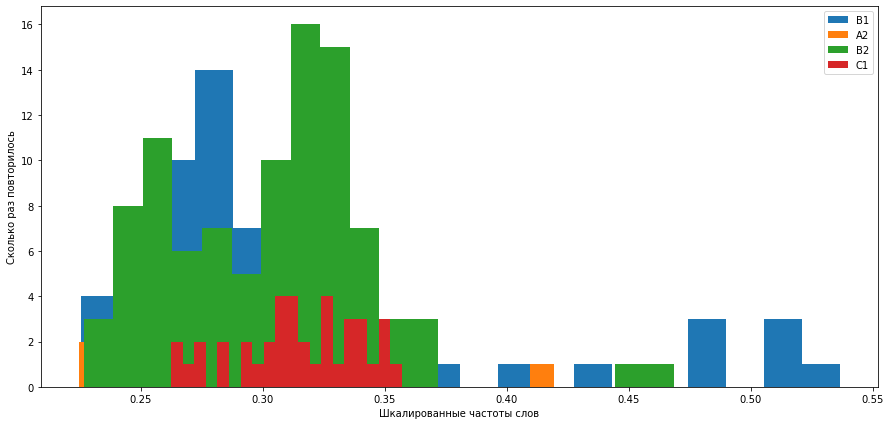

Расстояния вычислены методом euclidean


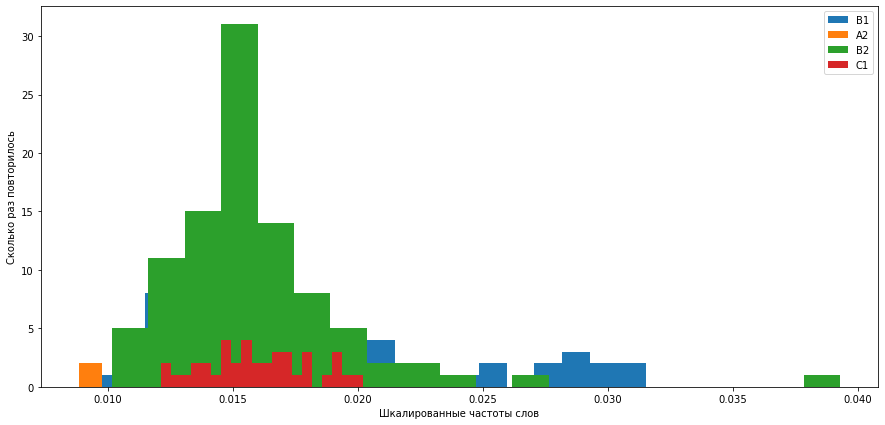

Расстояния вычислены методом cosine


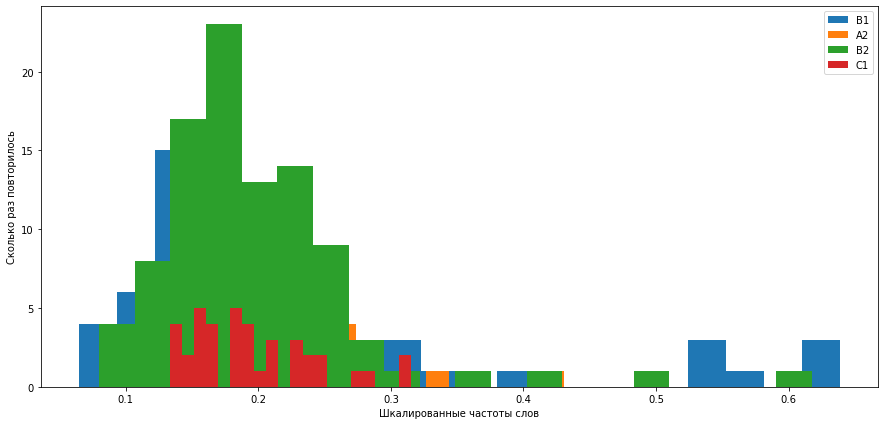

In [8]:
# Посмотрим на диаграммах, как распределяются расстояния по категориям относительно центров этих категорий
for distance in ['cityblock', 'euclidean', 'cosine']:
    print('Расстояния вычислены методом', distance)
    # зададим размер диаграммы
    plt.figure(figsize=(15, 7))
    # пройдёмся по уровням сложности отдельно
    for lvl in cut_data['Level'].unique():
        df = cut_data.query('Level == @lvl').drop('Level', axis=1) # срез данных по уровню
        dist = df.apply(strings_dist, args=(mean_cat[0].values, distance), axis=1) # расчёт расстояний
        # построение диграмм
        plt.hist(dist, bins=20)        
        plt.xlabel('Шкалированные частоты слов')
        plt.ylabel('Сколько раз повторилось')
    # добавим легенду на диграммы
    plt.legend(cut_data['Level'].unique())
    # сделаем так, чтобы все уровни показались на одной диаграмме
    plt.show()

In [9]:
# обернём перменную с усреднёнными значениями в фрейм данных
mean_cat = pd.DataFrame(data=np.array(mean_cat).T, columns=cut_data['Level'].unique())
display(mean_cat)

,B1,A2,B2,C1
0,0.000027,0.000013,0.000038,0.000027
1,0.000345,0.000192,0.000222,0.000197
2,0.000005,0.000007,0.000011,0.000014
3,0.000116,0.000103,0.000216,0.000292
4,0.000111,0.000059,0.000140,0.000092
...,...,...,...,...
4323,0.000000,0.000000,0.000000,0.000000
4324,0.000008,0.000000,0.000009,0.000009
4325,0.000000,0.000000,0.000000,0.000000
4326,0.000000,0.000005,0.000004,0.000000


***Как можем видеть, по данным диаграммам, все способы расчета дают разные значения расстояний. Однако, можем наблюдать, что большая часть значений расстояний лежит в левой части диаграмм. Из этого можно сделать вывод, что значения лежачие справа скорее всего точно будут относится к той или иной сложности языка. Исходя из это можем построить классификатор, который поможет сделать разметку для новых текстов.***

# Проверка на адекватность "ансамбля" классификаторов

***Качество разработанного классификатора получилось достойное. Теперь можно его применить для разметки новых данных.***

Стоит отметить, что в ходе проекта для обработки текста была задействована только ***лематизация*** текстов и уже даже с ней получилось задействовать "ансамбль" из 9 слабых классификаторов, позволивших производить разметку с точностью 0.8!!! Потенциально можно ***лематизацию*** заменить на ***стеминг*** и получить уже 18 слабых классификаторов! Также можно вообще убрать данные методы и попробовать без них и получить уже 27. Такими не хитрыми действиями можно получить потенциально качественный "ансамбль", что не может не радовать). Также возможно получится добавить еще различных методов для оценки близости.

Стоит добавить, что в дальнейшем с развитием модели отказываться от работы созданного уже сильного классификатора не стоит, можно будет добавить весовые коэффициенты для каждого классификатора, чтобы в явном виде определять вклад каждого в результат. 

# Обработка файлов с новыми субтитрами

**Получим фрейм данных для новых субтитров.**

**Сохраним получившийся фрейм данных в файл, чтобы в будущем его можно было быстрее использовать и не производить расчёт каждый раз.**

# Обучение модели на новых данных

Итак мы имеем:
* фрейм данных, содержащий масштабированные частоты слов для исходных субтитров;
* обученную на исходных данных модель CatBoost;
* новый фрейм данных, в котором хранятся уже новые обработанные субтитры с масштабированными частотами слов.

## Подготовка данных

**Теперь объединим фреймы в один, произведём новое обучение модели и оценим итоговый результат.**

In [13]:
# объединение фреймов в один
united_data = pd.concat([data.drop('id', axis=1), new_data], ignore_index=True)
display(united_data)

,ability,able,abroad,accept,accident,according to,achieve,act,active,actually,...,roster,rumor,setup,skeptical,sophomore,superintendent,tumor,unconstitutional,Movie,Level
0,0.0,0.001036,0.0,0.000345,0.001036,0,0.000000,0.000000,0.000000,0.000691,...,0.0,0.000000,0.000000,0,0.000000,0.0,0.0,0,10_Cloverfield_lane(2016),B1
1,0.0,0.000235,0.0,0.000235,0.000000,0,0.000000,0.000471,0.000000,0.001883,...,0.0,0.000471,0.000235,0,0.000471,0.0,0.0,0,10_things_I_hate_about_you(1999),B1
2,0.0,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0,0.000000,0.0,0.0,0,Aladdin(1992),A2
3,0.0,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000225,...,0.0,0.000000,0.000000,0,0.000000,0.0,0.0,0,All_dogs_go_to_heaven(1989),A2
4,0.0,0.000467,0.0,0.000234,0.000234,0,0.000000,0.000234,0.000234,0.000935,...,0.0,0.000000,0.000000,0,0.000000,0.0,0.0,0,AmericanBeauty1999.BRRip,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.0,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000814,0.000000,0.000000,...,0.0,0.000000,0.000000,0,0.000000,0.0,0.0,0,Twisted.Metal.S01E09.PCOK.WEB.h264-EDITH_HI.en,A2
347,0.0,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0,0.000000,0.0,0.0,0,Twisted.Metal.S01E10.PCOK.WEB.h264-EDITH_HI.en,A2
348,0.0,0.000674,0.0,0.000898,0.000000,0,0.000000,0.001123,0.000000,0.000449,...,0.0,0.000225,0.000000,0,0.000000,0.0,0.0,0,Victoria.2016.720p.BluRay.x264.AAC-[YTS.MX].en,B2
349,0.0,0.000762,0.0,0.000305,0.000000,0,0.000305,0.000000,0.000000,0.000610,...,0.0,0.000305,0.000000,0,0.000000,0.0,0.0,0,Who.Killed.The.Electric.Car.LiMiTED.DVDRip.Xvi...,B2


Подготовка новых данных для обучения модели

In [14]:
# разделим данные на признаки и целевые значения
features = united_data.drop(['Movie', 'Level'], axis=1)
target = united_data['Level']

# разделим на выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.2, random_state=12345)

## Разработка модели

Наконец произведём обучение модели на новых данных!

In [15]:
best_params = {'eval_metric': 'MultiClassOneVsAll',
              'loss_function': 'MultiClassOneVsAll',
              'learning_rate': 0.009, 
              'random_seed': 12345,
              'verbose':100}

# Создаём модель
New_model = CatBoostClassifier(**best_params)

# обучим модель
New_model.fit(features_train, target_train)

0:	learn: 0.6909895	total: 290ms	remaining: 4m 49s
100:	learn: 0.5570479	total: 8s	remaining: 1m 11s
200:	learn: 0.4888143	total: 15.8s	remaining: 1m 2s
300:	learn: 0.4432758	total: 23.7s	remaining: 55.1s
400:	learn: 0.4066906	total: 31.6s	remaining: 47.3s
500:	learn: 0.3752179	total: 39.5s	remaining: 39.3s
600:	learn: 0.3468927	total: 47.3s	remaining: 31.4s
700:	learn: 0.3205765	total: 55.5s	remaining: 23.7s
800:	learn: 0.2923271	total: 1m 3s	remaining: 15.8s
900:	learn: 0.2645718	total: 1m 11s	remaining: 7.82s
999:	learn: 0.2403827	total: 1m 18s	remaining: 0us


Оценим качество получившейся модели

In [16]:
# произведём проверку на тестовой выборке
new_predicted_test = New_model.predict(features_test)

# оценим качество по метрике F1
scoring_f1 = f1_score(target_test, new_predicted_test, average='weighted')
print('Качество модели по метрике F1:', scoring_f1)

# оценим качество по метрике Accuracy
accuracy_scoring = accuracy_score(target_test, new_predicted_test)
print('Качество модели по метрике Accuracy:', accuracy_scoring)

Качество модели по метрике F1: 0.6066482812961687
Качество модели по метрике Accuracy: 0.647887323943662


***Как можем наблюдать, вся проделанная работа была не зря. Удалось поднять качество модели на целых ~20% и ~16% для метрик F1 и Accuracy соответственно. Для сравнения, качество на исходных данных было следующим: по метрике F1: 0.3967718268525312 и по метрике Accuracy: 0.48936170212765956.***

**Важное замечание:** если бы исходных размеченных данных было ощутимо больше, то точность прогноза можно было бы существенно повысить. Также, не маловажным фактором является то, насколько качественно была произведена разметка исходных субтитров. Фактически, "ансамбль" классификаторов целиком и полностью упирается в то, насколько грамотно были размечены данные изначально.

# Выводы

В ходе работы над данным проектом была произведена обработка субтитров и файлов с уровнями сложности языка, разработана модель и создан классификатор для разметки новых данных.

1) Обработка субтитров.

Для работы с субтитрами были разработаны функции:
* удаление лишних символов (спец. символы "?:%?&", а также цифры);
* токенизация текстов (разбиение на слова) и их преобразование к исходной форме;
* произведён подсчёт количества повторений каждого слова в тексте (на основе слов содержащихся в файлах с уровнями сложности), а также полученные значения были отмасштабированны по долям относительно всех слов для каждого текста).

Полученные датасеты были сохранены в отдельные файлы для получения уже готовых фреймов с данными.

2) Разработка модели.

Для разработки была выбрана модель из пакета CatBoost, так как данные модели не требуют серьезного вмешательства в свои параметры (хоть такая возможность и есть), однако даже с базовыми значениями данная модель выдаёт хорошее качество, что нам и нужно для нашего исследования. Начальная модель была обучена на исходных данных и получила значение метрик качества F1 - ~0.397 и Accuracy - ~0.489. (что явно говорит о том что использовать их нельзя).

3) Разметка новых данных.

Для того, чтобы разметить новые данные были разработаны функции:
* вычисление меры близости между строками, это расчёт расстояний (Евклидово, Манхеттеннское и Косинусное), а также мер похожести (корреляции Пирсона, Спирмена и Кендалла);
* определение сложности текста на основе вычислений количества вхождений самых встречаемых слов из текста в уровни сложности языка (к сожалению так и не получилось реализовать граммтный алгоритм для работы данной функции);
* определение сложности на основе предсказаний обученой на исходных данных модели.

По результатам работы данных функций был создан "ансамбль слабых классификаторов", который позволил осуществить разметку новых данных.

4) Обучение модели на новой увеличенной выборке.

По результатам обработки новых субтитров, а также осуществления разметки полученных данных, был создан новый фрейм данных, включащий в себя массив исходных данных, а также новых. В ходе обучения модели уже на новом датасете, получилось поднять качество модели на целых ~20% и ~16% для метрик F1 и Accuracy соответственно (F1: ~0.606 и Accuracy: ~0.647). Имея полученные результаты, можем с уверенностью сказать, что при дальнейшем развитии проекта, усложнении "ансамбля слабых классификаторов" можно поднять качество предсказаний довольно существенно, возможно если для предсказаний использовать модель в составе "ансамбля" с весовыми коэффициентами, то можно поднять качество и до приемлемых 90%!!! Что просто фантастика!. Главным "камнем преткновения" является разметка исходных данных, а точнее насколько качественно она была произведена.

P.S.: Добавлен класс, для получения предсказаний по новым файлам, при небольшой доработке, его можно будет использовать в случае развёртывания системы с онлайн доступом (на данном этапе он реализован, чтобы работать с текущими настройками, когда файл кидается в какую-нибудь папку).